In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

data_dir = Path("../data")
president_csv = data_dir / "president.csv"
president_rates_csv = data_dir / "president_rates.csv"
president_rates_fth = data_dir / "president_rates.fth"
president_changes_fth = data_dir / "president_changes.fth"
president_changes_csv = data_dir / "president_changes.csv"

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

# Data

In [2]:
votes = pd.read_csv(president_csv,
                    dtype={
                        "RECEIVED_VOTES": np.int32,
                        "VALID_VOTES": np.int32,
                        "INVALID_VOTES": np.int32,
                        "ISSUED_VOTES": np.int32,
                        "UNISSUED_VOTES": np.int32,
                        "POPULATION": np.int32,
                        "VOTING_RATE": np.float32,
                    }); votes

,YEAR,CITY_COUNTY,TOWNSHIP_CITY,VILLAGE,BOOTH_NUMBER,CANDIDATE,PARTY,RECEIVED_VOTES,VALID_VOTES,INVALID_VOTES,ISSUED_VOTES,UNISSUED_VOTES,POPULATION,VOTING_RATE
0,2008,臺北市,北投區,建民里,1,(1)謝長廷蘇貞昌,DPP,711,1312,12,1324,359,1683,78.669998
1,2008,臺北市,北投區,建民里,1,(2)馬英九蕭萬長,KMT,601,1312,12,1324,359,1683,78.669998
2,2008,臺北市,北投區,建民里,2,(1)謝長廷蘇貞昌,DPP,685,1391,4,1395,333,1728,80.730003
3,2008,臺北市,北投區,建民里,2,(2)馬英九蕭萬長,KMT,706,1391,4,1395,333,1728,80.730003
4,2008,臺北市,北投區,文林里,3,(1)謝長廷蘇貞昌,DPP,458,940,6,946,234,1180,80.169998
5,2008,臺北市,北投區,文林里,3,(2)馬英九蕭萬長,KMT,482,940,6,946,234,1180,80.169998
6,2008,臺北市,北投區,文林里,4,(1)謝長廷蘇貞昌,DPP,485,1103,9,1112,192,1304,85.279999
7,2008,臺北市,北投區,文林里,4,(2)馬英九蕭萬長,KMT,618,1103,9,1112,192,1304,85.279999
8,2008,臺北市,北投區,文林里,5,(1)謝長廷蘇貞昌,DPP,435,995,5,1000,233,1233,81.099998
9,2008,臺北市,北投區,文林里,5,(2)馬英九蕭萬長,KMT,560,995,5,1000,233,1233,81.099998


In [16]:
def compute_rates(votes):
    df = votes.copy()
    df = df.drop(df[df.PARTY == "PFP"].index)
    for col in ["BOOTH_NUMBER", "CANDIDATE", "VALID_VOTES", "INVALID_VOTES", "UNISSUED_VOTES",
                "VOTING_RATE"]:
        del df[col]
    rates = df.groupby(
        ["CITY_COUNTY", "TOWNSHIP_CITY", "VILLAGE", "YEAR", "PARTY"]
    ).aggregate({
        "RECEIVED_VOTES": "sum",
        "ISSUED_VOTES": "sum",
        "POPULATION": "sum",
    })
    rates["RATE"] = rates.RECEIVED_VOTES / rates.ISSUED_VOTES
    return rates

rates = compute_rates(votes); display_all(rates)

RECEIVED_VOTES  ISSUED_VOTES  \
CITY_COUNTY TOWNSHIP_CITY VILLAGE YEAR PARTY                                 
南投縣         中寮鄉           中寮村     2008 DPP               150           514   
                                       KMT               360           514   
                                  2012 DPP               199           469   
                                       KMT               261           469   
                                  2016 DPP               189           372   
...                                                      ...           ...   
高雄縣         鳳山市           鳳崗里     2008 KMT               540           916   
                          鳳東里     2008 DPP              1583          3363   
                                       KMT              1762          3363   
                          龍成里     2008 DPP              1140          2097   
                                       KMT               922          2097   

                                              POPULATION      RATE  
CITY_COUNTY TOWNSHIP_CITY VILLAGE YEAR PARTY                        
南投縣         中寮鄉           中寮村     2008 DPP           700  0.291829  
                                       KMT           700  0.700389  
                                  2012 DPP           699  0.424307  
                                       KMT           699  0.556503  
                                  2016 DPP           662  0.508065  
...                                                  ...       ...  
高雄縣         鳳山市           鳳崗里     2008 KMT          1185  0.589520  
                          鳳東里     2008 DPP          4209  0.470711  
                                       KMT          4209  0.523937  
                          龍成里     2008 DPP          2635  0.543634  
                                       KMT          2635  0.439676  

[46860 rows x 4 columns]

In [17]:
rates.reset_index().to_csv(president_rates_csv, index=None)
rates.reset_index().to_feather(president_rates_fth)

# Explore

In [18]:
from sqlalchemy import create_engine

def get_conn():
    POSTGRES_HOST = "localhost"
    POSTGRES_PORT = "5432"
    POSTGRES_USER = "postgres"
    POSTGRES_PASSWORD = "mysecret"
    POSTGRES_DBNAME = "mydb"

    postgres_str = "postgresql://{user}:{password}@{host}:{port}/{dbname}".format(
        user=POSTGRES_USER, password=POSTGRES_PASSWORD, host=POSTGRES_HOST, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME)

    return create_engine(postgres_str)

conn = get_conn()

In [19]:
pd.read_sql_query("SELECT * FROM rates WHERE year = 2016 LIMIT 8;", conn)

,city_county,township_city,village,year,party,received_votes,issued_votes,population,rate
0,南投縣,中寮鄉,中寮村,2016,DPP,189,372,662,0.508065
1,南投縣,中寮鄉,中寮村,2016,KMT,132,372,662,0.354839
2,南投縣,中寮鄉,內城村,2016,DPP,140,267,458,0.524345
3,南投縣,中寮鄉,內城村,2016,KMT,87,267,458,0.325843
4,南投縣,中寮鄉,八仙村,2016,DPP,256,459,778,0.557734
5,南投縣,中寮鄉,八仙村,2016,KMT,135,459,778,0.294118
6,南投縣,中寮鄉,和興村,2016,DPP,218,372,661,0.586021
7,南投縣,中寮鄉,和興村,2016,KMT,101,372,661,0.271505


A particular village where DPP support rised at 2012 but dropped at 2016.

In [22]:
pd.read_sql_query("SELECT * FROM rates WHERE village = '南津里';", conn)

,city_county,township_city,village,year,party,received_votes,issued_votes,population,rate
0,宜蘭縣,宜蘭市,南津里,2008,DPP,353,696,940,0.507184
1,宜蘭縣,宜蘭市,南津里,2008,KMT,338,696,940,0.485632
2,宜蘭縣,宜蘭市,南津里,2012,DPP,397,744,1003,0.533602
3,宜蘭縣,宜蘭市,南津里,2012,KMT,326,744,1003,0.438172
4,宜蘭縣,宜蘭市,南津里,2016,DPP,516,1209,1880,0.426799
5,宜蘭縣,宜蘭市,南津里,2016,KMT,551,1209,1880,0.455749


# Analysis

## Rates of DPP and KMT by years

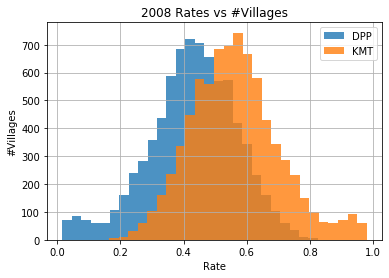

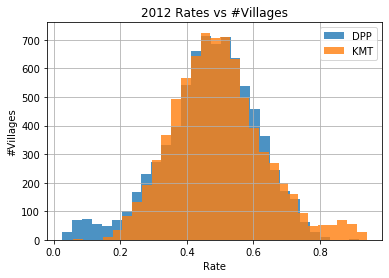

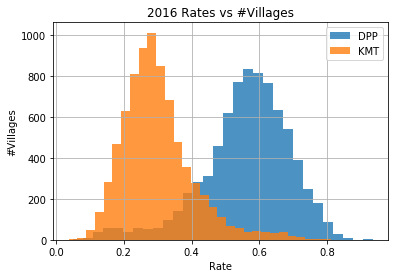

In [28]:
for year in [2008, 2012, 2016]:
    for party in ["DPP", "KMT"]:
        df = pd.read_sql_query("SELECT rate FROM rates WHERE year = {year} AND party = '{party}';".format(
            year = year, party = party
        ), conn)
        df.rate.hist(bins=30, alpha=0.8, label=party)
    plt.title("{year} Rates vs #Villages".format(year=year))
    plt.xlabel("Rate")
    plt.ylabel("#Villages")
    plt.legend()
    plt.show()

## DPP over KMT rates by years

In [25]:
_ = conn.execute("""
    CREATE TABLE dpp_over_kmt_rates AS
    SELECT city_county, township_city, village, year, issued_votes, population, rate - (
        SELECT rate FROM rates WHERE
           year = r0.year
           AND city_county = r0.city_county
           AND township_city = r0.township_city
           AND village = r0.village
           AND party = 'KMT'
           LIMIT 1
           ) AS dpp_over_kmt_rate
        FROM rates AS r0 WHERE party = 'DPP';
    """)

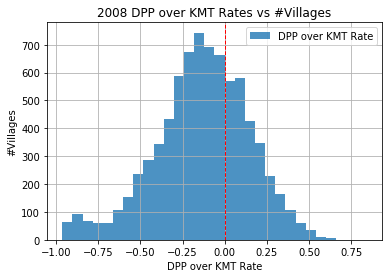

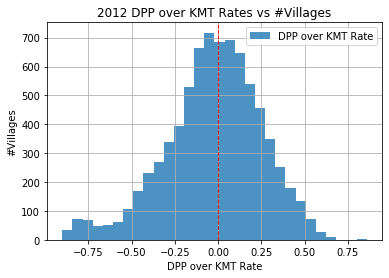

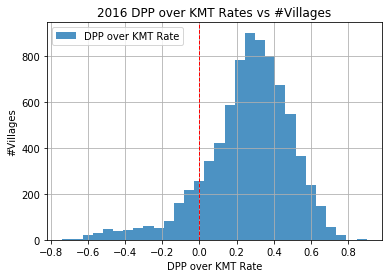

In [31]:
for year in [2008, 2012, 2016]:
    df = pd.read_sql_query(
        """
        SELECT * FROM dpp_over_kmt_rates WHERE year = {year};
        """.format(year = year), conn)
    df.dpp_over_kmt_rate.hist(bins=30, alpha=0.8, label="DPP over KMT Rate")
    
    plt.axvline(0.00, color="red", linestyle="dashed", linewidth=1)
    plt.title("{year} DPP over KMT Rates vs #Villages".format(year=year))
    plt.xlabel("DPP over KMT Rate")
    plt.ylabel("#Villages")
    plt.legend()
    plt.show()

## Change of DPP over KMT rates by years

In [51]:
#_ = conn.execute("""DROP TABLE dpp_over_kmt_rate_changes;""")
_ = conn.execute("""
    CREATE TABLE dpp_over_kmt_rate_changes AS
        SELECT city_county, township_city, village,
            issued_votes AS issued_votes_2016,
            population AS population_2016, 
            (SELECT dpp_over_kmt_rate FROM dpp_over_kmt_rates WHERE
                city_county = r0.city_county
                AND township_city = r0.township_city
                AND village = r0.village
                AND year = 2008
                LIMIT 1)
            AS dpp_over_kmt_rates_2008,
            (SELECT dpp_over_kmt_rate FROM dpp_over_kmt_rates WHERE
                city_county = r0.city_county
                AND township_city = r0.township_city
                AND village = r0.village
                AND year = 2012
                LIMIT 1)
            AS dpp_over_kmt_rates_2012,
            dpp_over_kmt_rate AS dpp_over_kmt_rates_2016
        FROM dpp_over_kmt_rates AS r0 WHERE year = 2016;
        """)

In [52]:
president_changes = pd.read_sql_query("""
    SELECT *,
    dpp_over_kmt_rates_2012 - dpp_over_kmt_rates_2008 AS changes_at_2012,
    dpp_over_kmt_rates_2016 - dpp_over_kmt_rates_2012 AS changes_at_2016
    FROM dpp_over_kmt_rate_changes;
""", conn)

president_changes.to_csv(president_changes_csv, index=None)

In [53]:
president_changes.describe()

,issued_votes_2016,population_2016,dpp_over_kmt_rates_2008,dpp_over_kmt_rates_2012,dpp_over_kmt_rates_2016,changes_at_2012,changes_at_2016
count,7825.000000,7825.000000,4655.000000,7136.000000,7825.000000,4652.000000,7136.000000
mean,1590.874505,2400.382236,-0.148065,-0.015012,0.260528,0.104831,0.283073
std,1283.802883,1907.546589,0.291925,0.276377,0.231260,0.047480,0.075144
min,30.000000,77.000000,-0.956456,-0.900000,-0.736842,-0.310953,-0.237404
25%,638.000000,1000.000000,-0.321813,-0.171315,0.149559,0.077022,0.237158
50%,1200.000000,1820.000000,-0.123994,0.007027,0.287951,0.102227,0.289366
75%,2252.000000,3360.000000,0.063638,0.173168,0.415556,0.130539,0.330860
max,19419.000000,30380.000000,0.699704,0.858238,0.898383,0.466117,0.709280


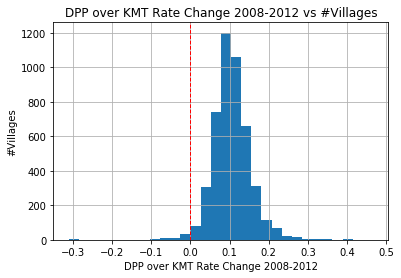

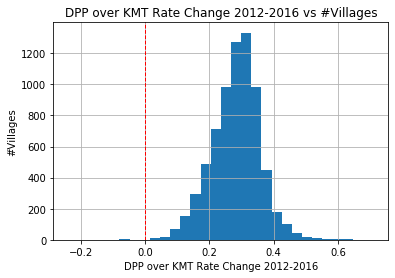

In [54]:
for year in [2012, 2016]:
    president_changes[f"changes_at_{year}"].hist(bins=30)
    plt.axvline(0.00, color="red", linestyle="dashed", linewidth=1)
    year_range = f"{year - 4}-{year}"
    plt.title(f"DPP over KMT Rate Change {year_range} vs #Villages")
    plt.xlabel(f"DPP over KMT Rate Change {year_range}")
    plt.ylabel("#Villages")
    plt.show()

## A list of villages

In [55]:
villages = \
    president_changes[president_changes.dpp_over_kmt_rates_2016 < 0.4][president_changes.changes_at_2016 < 0.1].sort_values("changes_at_2016")
villages["fullvill"] = villages.city_county + villages.township_city + villages.village
villages.to_csv(data_dir / "villages.csv", index=None)
display_all(villages)

/Users/pm5/.local/share/virtualenvs/tracevotes-jrj40fyZ/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,city_county,township_city,village,issued_votes_2016,population_2016,dpp_over_kmt_rates_2008,dpp_over_kmt_rates_2012,dpp_over_kmt_rates_2016,changes_at_2012,changes_at_2016,fullvill
6008,臺東縣,臺東市,豐樂里,868,1433,NaN,0.267358,0.029954,NaN,-0.237404,臺東縣臺東市豐樂里
7695,高雄市,鳳山區,中正里,2684,3828,NaN,-0.315183,-0.471684,NaN,-0.156501,高雄市鳳山區中正里
973,宜蘭縣,宜蘭市,南津里,1209,1880,0.021552,0.095430,-0.028950,0.073878,-0.124380,宜蘭縣宜蘭市南津里
957,宜蘭縣,大同鄉,太平村,43,81,0.020833,0.271186,0.186047,0.250353,-0.085140,宜蘭縣大同鄉太平村
7184,高雄市,大樹區,統嶺里,511,710,NaN,0.445585,0.381605,NaN,-0.063980,高雄市大樹區統嶺里
4015,澎湖縣,白沙鄉,小赤村,80,166,-0.070707,0.063158,0.100000,0.133865,0.036842,澎湖縣白沙鄉小赤村
3109,新北市,貢寮區,吉林里,294,469,NaN,0.181818,0.221088,NaN,0.039270,新北市貢寮區吉林里
3112,新北市,貢寮區,福連里,546,911,NaN,0.283358,0.335165,NaN,0.051806,新北市貢寮區福連里
2478,新北市,平溪區,東勢里,284,442,NaN,0.123839,0.179577,NaN,0.055739,新北市平溪區東勢里
6645,雲林縣,古坑鄉,湳仔村,450,684,0.195695,0.279923,0.340000,0.084228,0.060077,雲林縣古坑鄉湳仔村


In [56]:
villages.city_county.value_counts()

雲林縣    5
新北市    4
高雄市    4
嘉義縣    3
澎湖縣    3
宜蘭縣    2
屏東縣    2
臺東縣    1
基隆市    1
苗栗縣    1
Name: city_county, dtype: int64